In [13]:
# -*- coding: utf-8 -*-
# @Time : 2023/9/25 13:55
# @Author : GuoPeng
from time import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


def calculate_center(gray_img, perimeter_thred=100, kernel_size=1):
    """
    读取一张0、1二值灰度图，剔除周长小于perimeter_thred的连通域，返回剩余连通域的中心点
    :param gray_img: 0、1二值灰度图
    :param perimeter_thred: 周长阈值
    :param kernel_size: 膨胀核大小
    :return:连通域的中心点[(高、宽)， (高、宽)·····]
    """

    # 膨胀操作，合并连通域
    t = time()
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gray_img = cv2.dilate(gray_img.astype(np.uint8), kernel, iterations=1)

    # 使用连通组件标记来标记和提取连通域
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(gray_img)

    # 初始化变量来存储连通域的中心点坐标和最近的点坐标
    connected_components_centers = []
    perimeters = []

    # 遍历每个连通域，跳过背景（标签为0）
    for label in range(1, len(stats)):
        # 获取连通域的中心点
        cX, cY = centroids[label]
        cX, cY = int(cX), int(cY)

        # 获取当前连通域的像素坐标
        pixels_in_component = np.argwhere(labels == label)

        # 计算周长
        perimeter = calculate_perimeter(labels, label)

        if perimeter >= perimeter_thred:
            if labels[cY, cX] <= 0:
                # 计算中心点到该连通域内所有点的距离
                distances = cdist(np.array([(cY, cX)]), pixels_in_component)

                # 找到离中心点最近的点
                min_distance_index = np.argmin(distances)
                closest_point = tuple(pixels_in_component[min_distance_index])
                (cY, cX) = closest_point
            connected_components_centers.append((cX, cY))
            perimeters.append(perimeter)

    # # 将连通域和中心点绘制到图像上
    labeled_image = gray_img

    for center_point, perimeter in zip(connected_components_centers, perimeters):
        # 绘制中心点
        cv2.circle(gray_img, center_point, 5, 2, -1)
        # 绘制周长
        cv2.putText(gray_img, str(int(perimeter)), center_point, cv2.FONT_HERSHEY_SIMPLEX, 2, 2, 3)

    # 坐标反转，由(宽、高)，变为(高、宽)
    connected_components_centers = [i[::-1] for i in connected_components_centers]
    print('杂质个数：', len(connected_components_centers))
    print("后处理时间：", time()-t)
    # 显示图像
    plt.imshow(gray_img)
    plt.axis('off')
    plt.show()

    return connected_components_centers


def calculate_perimeter(label_image, label):
    """
    计算标签为label的连通域的周长
    :param label_image: 使用cv2.connectedComponentsWithStats计算出来的连通域图
    :param label:
    :return:所有标签为label的连通域周长之和
    """
    mask = (label_image == label).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_length = 0

    for contour in contours:
        contour_length += cv2.arcLength(contour, closed=True)

    return contour_length



226
1
杂质个数： 8
后处理时间： 0.03973746299743652


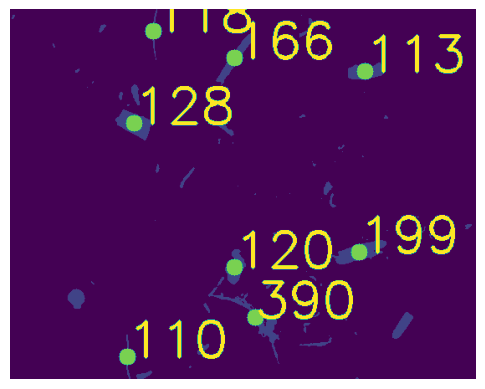

0.0726165771484375
[(26, 171), (58, 268), (74, 424), (136, 148), (290, 417), (308, 268), (368, 293), (415, 140)]


In [11]:
if __name__ == '__main__':
    gray_img = cv2.imread(r'1.png', cv2.IMREAD_GRAYSCALE)
    print(gray_img.max())
    gray_img[gray_img<=150] = 0
    gray_img[gray_img>=150] = 1
    print(gray_img.max())
    t1 = time()
    points = calculate_center(gray_img)
    print(time() - t1)
    print(points)

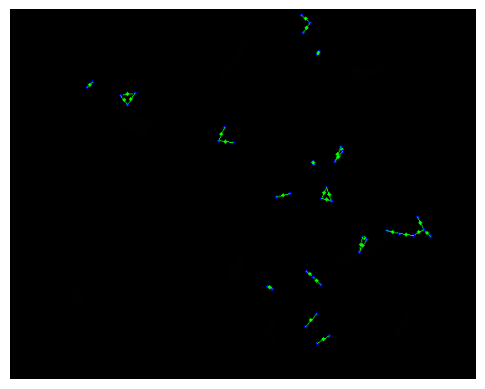

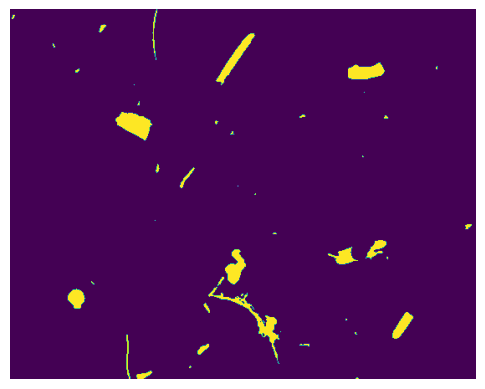

In [27]:
import cv2
import numpy as np

# 读取输入的二值化图像
gray_img = cv2.imread(r'1.png', cv2.IMREAD_GRAYSCALE)
gray_img[gray_img<=150] = 0
gray_img[gray_img>=150] = 1
image = gray_img
# 连通域分析
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)

# 设置距离阈值
distance_threshold = 20  # 根据需要调整距离阈值

# 计算最近的两个点的中点
def calculate_midpoint(point1, point2):
    return ((point1[0] + point2[0]) // 2, (point1[1] + point2[1]) // 2)

# 存储每个连通域的中心点坐标
centroids = centroids[1:]  # 去掉背景的中心点

# 存储满足条件的连通域中心点对及其中点
valid_pairs = []

for i in range(len(centroids)):
    for j in range(i+1, len(centroids)):
        point1 = (int(centroids[i][0]), int(centroids[i][1]))
        point2 = (int(centroids[j][0]), int(centroids[j][1]))
        distance = np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
        
        if distance < distance_threshold:
            midpoint = calculate_midpoint(point1, point2)
            valid_pairs.append((point1, point2, midpoint))

# 在原始图像上绘制中点
result_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

for point1, point2, midpoint in valid_pairs:
    cv2.circle(result_image, point1, 2, (0, 0, 255), -1)  # 用红色标记点1
    cv2.circle(result_image, point2, 2, (0, 0, 255), -1)  # 用红色标记点2
    cv2.circle(result_image, midpoint, 2, (0, 255, 0), -1)  # 用绿色标记中点
    cv2.line(result_image, point1, point2, (0, 255, 0), 1)  # 用绿色连接两点及中点

for point1, point2, midpoint in valid_pairs:
    cv2.circle(gray_img, point1, 10, (0, 0, 255), -1)  # 用红色标记点1
    cv2.circle(gray_img, point2, 10, (0, 0, 255), -1)  # 用红色标记点2
    cv2.circle(gray_img, midpoint, 10, (0, 255, 0), -1)  # 用绿色标记中点
    cv2.line(gray_img, point1, point2, (0, 255, 0), 1)  # 用绿色连接两点及中点

# 显示结果图像
plt.imshow(result_image)
plt.axis('off')
plt.show()
plt.imshow(gray_img)
plt.axis('off')
plt.show()

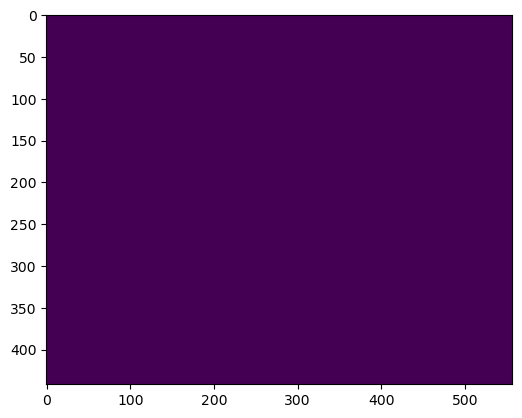

In [31]:
import cv2
import numpy as np

# 读取输入的二值化图像
# 读取输入的二值化图像
gray_img = cv2.imread(r'1.png', cv2.IMREAD_GRAYSCALE)
gray_img[gray_img<=150] = 0
gray_img[gray_img>=150] = 1
image = gray_img

# 执行距离变换
dist_transform = cv2.distanceTransform(image, cv2.DIST_L2, 3)

# 设置距离阈值
distance_threshold = 1  # 根据需要调整距离阈值

# 执行距离变换后，标记连通域
_, markers = cv2.connectedComponents((dist_transform < distance_threshold).astype(np.uint8))

# 合并满足条件的连通域
for label in range(1, np.max(markers) + 1):
    image[markers == label] = 1

# 创建合并后的图像
merged_image = image * 255

# 显示或保存结果图像
plt.imshow(merged_image)
plt.show()